# AI model for predicting the electricity prices

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from LSTMmodel import *
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
# moving to GPU if available (Metal)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## Loading the data

In [3]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,...,wind_speed_Thisted,wind_speed_Tønder,wind_speed_Varde,wind_speed_Vejen,wind_speed_Vejle,wind_speed_Vesthimmerlands,wind_speed_Viborg,wind_speed_Ærø,natural_gas,crude_oil
0,120.080002,2024-11-25 23:00:00+00:00,2024-11-26 00:00:00+00:00,8.8,7.8,8.0,8.8,8.5,7.8,9.2,...,10.9,6.8,8.0,6.7,5.5,6.9,5.9,7.7,2.78,74.27
1,298.309998,2024-11-25 22:00:00+00:00,2024-11-25 23:00:00+00:00,8.9,8.0,8.3,9.1,8.6,7.9,9.2,...,10.3,6.5,7.9,6.5,5.7,6.3,5.5,7.9,2.78,74.27
2,197.039993,2024-11-25 21:00:00+00:00,2024-11-25 22:00:00+00:00,9.1,8.5,8.6,9.3,8.8,8.4,9.4,...,10.2,6.5,7.6,6.6,5.7,6.4,5.7,7.8,2.78,74.27
3,227.539993,2024-11-25 20:00:00+00:00,2024-11-25 21:00:00+00:00,9.4,8.9,9.1,9.6,9.0,8.9,9.5,...,10.0,6.5,7.5,6.3,5.6,6.6,6.0,7.8,2.78,74.27
4,289.880005,2024-11-25 19:00:00+00:00,2024-11-25 20:00:00+00:00,9.7,9.6,9.6,9.8,9.4,9.6,9.7,...,9.2,7.3,7.6,7.1,5.8,6.8,6.7,7.4,2.78,74.27


(75864, 473)


## Data preprocessing

In [4]:
data['from'] = pd.to_datetime(data['from'])

# drop to column
data = data.drop(columns=['to'])

# explicitly including lagged prices as well
lag_hours = [0, 
            -1, -2, -3, -4, -5, -6, -24, #-48, -72, -96, -120, -144, -168
             ]
for lag in lag_hours:
    data[f'price_lag_{lag}'] = data['SpotPriceDKK'].shift(lag)

lag_oil_gas = [-24, -48, -72, # -168
               ]
for lag in lag_oil_gas:
    data[f'crude_oil_{lag}'] = data['crude_oil'].shift(lag)
    data[f'natural_gas_{lag}'] = data['natural_gas'].shift(lag)

# offset price by 1 day
data['SpotPriceDKK'] = data['SpotPriceDKK'].shift(24)
# drop the first 24 rows
data = data.dropna()

# offset the from date by 1 day to match the price
data['from'] = data['from'] + pd.DateOffset(days=1)

# cyclical encoding for hour, day, and month
data['hour'] = data['from'].dt.hour
data['day'] = data['from'].dt.dayofweek
data['month'] = data['from'].dt.month

cyclical_encoding(data,'hour',24)
cyclical_encoding(data,'day',7)
cyclical_encoding(data,'month',12)

# sort data to be ascending
data = data.sort_values('from')

display(data.head())
print(data.shape)

,SpotPriceDKK,from,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,temp_Faaborg-Midtfyn,...,natural_gas_-72,hour,day,month,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
75791,149.070007,2016-04-05 00:00:00+00:00,6.1,4.6,4.6,5.5,3.9,4.4,5.2,5.4,...,1.88,0,1,4,0.000000,1.000000,0.781831,0.62349,0.866025,-0.5
75790,147.580002,2016-04-05 01:00:00+00:00,6.8,4.1,4.0,5.5,3.5,3.8,5.1,5.0,...,1.88,1,1,4,0.258819,0.965926,0.781831,0.62349,0.866025,-0.5
75789,149.520004,2016-04-05 02:00:00+00:00,7.0,3.4,3.6,5.2,4.0,3.2,5.2,4.9,...,1.88,2,1,4,0.500000,0.866025,0.781831,0.62349,0.866025,-0.5
75788,158.300003,2016-04-05 03:00:00+00:00,7.8,2.7,3.6,5.5,4.8,2.5,6.2,5.1,...,1.88,3,1,4,0.707107,0.707107,0.781831,0.62349,0.866025,-0.5
75787,170.289993,2016-04-05 04:00:00+00:00,8.8,2.1,3.9,6.7,6.8,1.9,7.3,6.0,...,1.88,4,1,4,0.866025,0.500000,0.781831,0.62349,0.866025,-0.5


(75768, 495)


In [5]:
# extract column names
cols = data.columns.tolist()

# select features and target variable
all_features = cols[2:]
target = cols[:1]

print(f'Count of features before interaction terms: {len(all_features)}')
print(f'Target variable: {target}')

Count of features before interaction terms: 493
Target variable: ['SpotPriceDKK']


In [6]:
# training data: until July 2023
train_data = data[data['from'] < '2023-08-01']
# train_data = data[(data['from'] >= '2016-04-01') & (data['from'] < '2023-08-01')]

# validation data: July 2023 to December 2023
val_data = data[(data['from'] >= '2023-08-01') & (data['from'] < '2024-08-01')]

# Test data: 2024 and beyond
test_data = data[data['from'] >= '2024-08-01']

X_train = train_data[all_features].values
X_val = val_data[all_features].values
X_test = test_data[all_features].values

In [7]:
# initialize the scaler
scaler = StandardScaler()
pca = PCA(n_components=0.95)

# fit the scaler on the training features and transform
X_train_scaled = scaler.fit_transform(X_train)

# transform the validation and test features using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# fit the PCA on the training features and transform
X_train_pca = pca.fit_transform(X_train_scaled)

# transform the validation and test features using the same PCA
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [8]:
# extract target values
train_targets = train_data[target].values
val_targets = val_data[target].values
test_targets = test_data[target].values

## Model building

In [9]:
# set seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

# hyperparameters
seq_length = 24  # Use past 24 hours to form a sequence
batch_size = 256
input_dim = X_train_pca.shape[1]
output_dim = 1
learning_rate = 0.001

# hidden_dim = 256
# layer_dim = 2
# # regularization parameter
# lambda_l1 = 1 # Adjust based on desired regularization strength
# lambda_l2 = 1e-5 # Adjust based on desired regularization strength


# arrays for tuning
lambda_l1_array = [2e-1, 1e-1]
lambda_l2_array = [1e-5, 1e-6]
hidden_dim_array = [256, 512, 1024]
layer_dim_array = [2, 3, 4]

In [10]:
# create datasets
train_dataset = dataset(X_train_pca, train_targets, seq_length)
val_dataset = dataset(X_val_pca, val_targets, seq_length)
test_dataset = dataset(X_test_pca, test_targets, seq_length)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# # initialize the model
# model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# loss evaluation function
criterion = nn.MSELoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model training

In [11]:
# # training the model
# num_epochs = 150
# patience = 10  # for early stopping
# best_loss = np.inf
# counter = 0

# # initialize lists to store loss values
# training_losses = []
# validation_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()

#         # forward pass
#         outputs = model(X_batch)

#         mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

#         # L1 regularization
#         l1_loss = l1_regularization(model, lambda_l1)
#         l2_loss = l2_regularization(model, lambda_l2)

#         # calc total loss
#         loss = mse_loss + l1_loss + l2_loss

#         # backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()


#     # average training loss
#     avg_train_loss = train_loss / len(train_loader)
#     training_losses.append(avg_train_loss)

#     # validation
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs = model(X_batch)
#             mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
#             l1_loss = l1_regularization(model, lambda_l1)
#             l2_loss = l2_regularization(model, lambda_l2)
#             loss = mse_loss + l1_loss + l2_loss
#             val_losses.append(loss.item())

#     avg_val_loss = np.mean(val_losses)
#     validation_losses.append(avg_val_loss)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
#     # torch.save(model.state_dict(), 'output/last_model.pth')
    
#     # early stopping
#     if avg_val_loss < best_loss:
#         best_loss = avg_val_loss
#         counter = 0
#         # save the best model
#         torch.save(model.state_dict(), 'output/best_model.pth')
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping")
#             break



In [12]:
# # training the model
# num_epochs = 150
# patience = 10  # for early stopping
# best_loss_global = np.inf

# for hidden_dim in hidden_dim_array:
#     for layer_dim in layer_dim_array:
#         for lambda_l1 in lambda_l1_array:
#             for lambda_l2 in lambda_l2_array:
#                 torch.manual_seed(2024)
#                 np.random.seed(2024)
#                 model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#                 # set seed for reproducibility
#                 best_loss = np.inf
#                 counter = 0

#                 # initialize lists to store loss values
#                 training_losses = []
#                 validation_losses = []

#                 for epoch in range(num_epochs):
#                     model.train()
#                     train_loss = 0
#                     for X_batch, y_batch in train_loader:
#                         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                         optimizer.zero_grad()

#                         # forward pass
#                         outputs = model(X_batch)

#                         mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

#                         # L1 regularization
#                         l1_loss = l1_regularization(model, lambda_l1)
#                         l2_loss = l2_regularization(model, lambda_l2)

#                         # calc total loss
#                         loss = mse_loss + l1_loss + l2_loss

#                         # backward pass and optimization
#                         loss.backward()
#                         optimizer.step()

#                         train_loss += loss.item()


#                     # average training loss
#                     avg_train_loss = train_loss / len(train_loader)
#                     training_losses.append(avg_train_loss)

#                     # validation
#                     model.eval()
#                     val_losses = []
#                     with torch.no_grad():
#                         for X_batch, y_batch in val_loader:
#                             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                             outputs = model(X_batch)
#                             mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
#                             l1_loss = l1_regularization(model, lambda_l1)
#                             l2_loss = l2_regularization(model, lambda_l2)
#                             loss = mse_loss + l1_loss + l2_loss
#                             val_losses.append(loss.item())

#                     avg_val_loss = np.mean(val_losses)
#                     validation_losses.append(avg_val_loss)
#                     if (epoch + 1) % 10 == 0:
#                         print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
#                     # torch.save(model.state_dict(), 'output/last_model.pth')
                    
#                     # early stopping
#                     if avg_val_loss < best_loss:
#                         best_loss = avg_val_loss
#                         counter = 0
#                         # save the best model
#                         torch.save(model.state_dict(), f'output/best_model_{lambda_l1_array.index(lambda_l1)}_{lambda_l2_array.index(lambda_l2)}_{hidden_dim_array.index(hidden_dim)}_{layer_dim_array.index(layer_dim)}_new.pth')
#                         if best_loss < best_loss_global:
#                             best_loss_global = best_loss
#                             torch.save(model.state_dict(), f'output/best_model_global.pth')
#                     else:
#                         counter += 1
#                         if counter >= patience:
#                             print(f"Early stopping after {epoch} epochs. Best validation loss: {best_loss:.4f}")
#                             break
                    
#                     if epoch == (num_epochs - 1):
#                         print(f"Training stopped after {epoch} epochs. Best validation loss: {best_loss:.4f}")



In [13]:
# load in the all the models and print the best validation loss
best_val_loss = np.inf
for hidden_dim in hidden_dim_array:
    for layer_dim in layer_dim_array:
        for lambda_l1 in lambda_l1_array:
            for lambda_l2 in lambda_l2_array:
                model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
                try:
                    model.load_state_dict(torch.load(f'output/best_model_{lambda_l1_array.index(lambda_l1)}_{lambda_l2_array.index(lambda_l2)}_{hidden_dim_array.index(hidden_dim)}_{layer_dim_array.index(layer_dim)}_new.pth'))
                except:
                    continue
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        outputs = model(X_batch)
                        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
                        l1_loss = l1_regularization(model, lambda_l1)
                        l2_loss = l2_regularization(model, lambda_l2)
                        loss = mse_loss + l1_loss + l2_loss
                        val_losses.append(loss.item())

                avg_val_loss = np.mean(val_losses)

                predictions = []
                actuals = []
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        outputs = model(X_batch)
                        predictions.extend(outputs.squeeze().tolist())
                        actuals.extend(y_batch.tolist())
                rmse = np.sqrt(mean_squared_error(actuals, predictions))
                mae = mean_absolute_error(actuals, predictions)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_hidden_dim = hidden_dim
                    best_lambda_l1 = lambda_l1
                    best_lambda_l2 = lambda_l2
                    best_layer_dim = layer_dim
                print(f'Hidden dim:  {hidden_dim}, Layer dim: {layer_dim},  L1:    {lambda_l1},  L2:  {lambda_l2},    Validation Loss:     {avg_val_loss:.4f}')
                print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

print(f'Best: \n Hidden dim:  {best_hidden_dim}, Layer dim: {best_layer_dim},  L1:    {best_lambda_l1},  L2:  {best_lambda_l2},    Best Validation Loss:     {best_val_loss:.4f}')

Hidden dim:  256, Layer dim: 2,  L1:    0.2,  L2:  1e-05,    Validation Loss:     83012.5805
RMSE: 372.2415, MAE: 289.2929
Hidden dim:  256, Layer dim: 2,  L1:    0.2,  L2:  1e-06,    Validation Loss:     91309.3856
RMSE: 391.2180, MAE: 304.4892
Hidden dim:  256, Layer dim: 2,  L1:    0.1,  L2:  1e-05,    Validation Loss:     81940.9179
RMSE: 382.7634, MAE: 295.4201
Hidden dim:  256, Layer dim: 2,  L1:    0.1,  L2:  1e-06,    Validation Loss:     88811.7474
RMSE: 380.3653, MAE: 293.0885
Hidden dim:  256, Layer dim: 3,  L1:    0.2,  L2:  1e-05,    Validation Loss:     102434.1999
RMSE: 400.5800, MAE: 310.4385
Hidden dim:  256, Layer dim: 3,  L1:    0.2,  L2:  1e-06,    Validation Loss:     102426.8935
RMSE: 399.2710, MAE: 308.8820
Hidden dim:  256, Layer dim: 3,  L1:    0.1,  L2:  1e-05,    Validation Loss:     102149.3795
RMSE: 400.5007, MAE: 310.3473
Hidden dim:  256, Layer dim: 3,  L1:    0.1,  L2:  1e-06,    Validation Loss:     102151.2340
RMSE: 399.0494, MAE: 308.6087
Hidden dim: 

In [13]:
# current best hyperparameters
opt_hidden_dim = 512
opt_lambda_l1 = 0.1
opt_lambda_l2 = 0.0001
opt_layer_dim = 3

torch.manual_seed(2024)
np.random.seed(2024)
# initialize the model
model = LSTMmodel(input_dim, opt_hidden_dim, opt_layer_dim, output_dim).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# training the model
num_epochs = 150
patience = 10  # for early stopping
best_loss = np.inf
counter = 0

# initialize lists to store loss values
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_batch)

        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # L1 regularization
        l1_loss = l1_regularization(model, opt_lambda_l1)
        l2_loss = l2_regularization(model, opt_lambda_l2)

        # calc total loss
        loss = mse_loss + l1_loss + l2_loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    # average training loss
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
            l1_loss = l1_regularization(model, opt_lambda_l1)
            l2_loss = l2_regularization(model, opt_lambda_l2)
            loss = mse_loss + l1_loss + l2_loss
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    validation_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    # torch.save(model.state_dict(), 'output/last_model.pth')
    
    # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        # save the best model
        torch.save(model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch [1/150], Training Loss: 641268.1453, Validation Loss: 246613.2942
Epoch [2/150], Training Loss: 546247.2014, Validation Loss: 177411.7026
Epoch [3/150], Training Loss: 490161.1279, Validation Loss: 137461.3805
Epoch [4/150], Training Loss: 458030.3779, Validation Loss: 116495.2883
Epoch [5/150], Training Loss: 442075.3384, Validation Loss: 107009.8016
Epoch [6/150], Training Loss: 434906.8182, Validation Loss: 104060.8464
Epoch [7/150], Training Loss: 432879.5056, Validation Loss: 104108.3680
Epoch [8/150], Training Loss: 431413.9341, Validation Loss: 126765.9346
Epoch [9/150], Training Loss: 375329.0015, Validation Loss: 102571.4006
Epoch [10/150], Training Loss: 326570.7184, Validation Loss: 105688.3220
Epoch [11/150], Training Loss: 291583.6218, Validation Loss: 96799.1064
Epoch [12/150], Training Loss: 262145.9697, Validation Loss: 95984.0489
Epoch [13/150], Training Loss: 233441.2935, Validation Loss: 97118.1906
Epoch [14/150], Training Loss: 208604.5467, Validation Loss: 88

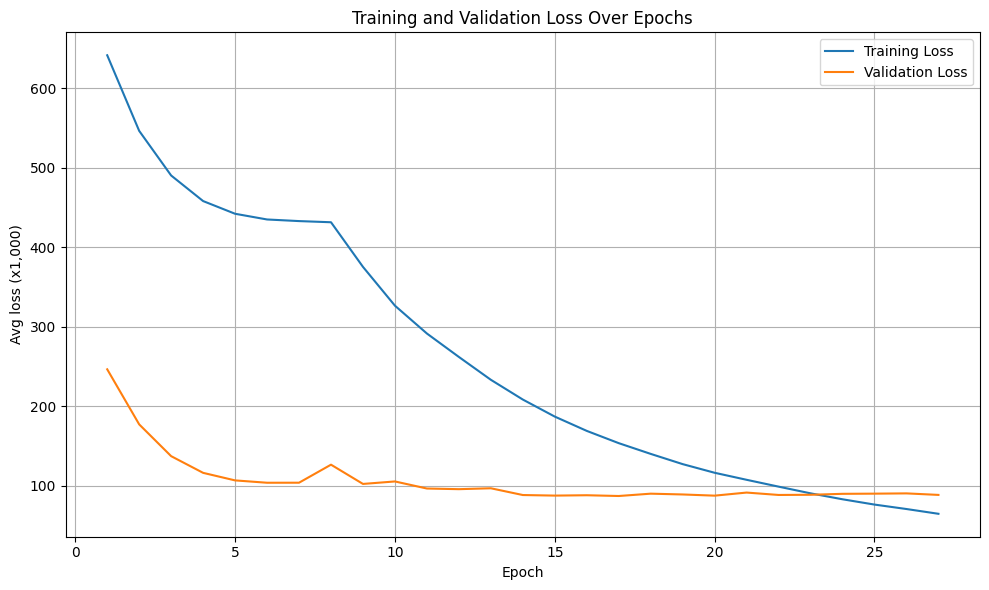

In [15]:
train_losses = np.array(training_losses)/1000
val_losses = np.array(validation_losses)/1000

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg loss (x1,000)')
# plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model evaluation and plotting

In [ ]:
# load the best model
model = LSTMmodel(input_dim, opt_hidden_dim, opt_layer_dim, output_dim).to(device)
# model.load_state_dict(torch.load(f'output/best_model_{lambda_l1_array.index(best_lambda_l1)}_{lambda_l2_array.index(best_lambda_l2)}_{hidden_dim_array.index(best_hidden_dim)}.pth'))
model.load_state_dict(torch.load('output/best_model.pth'))

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.squeeze().tolist())
        #

        actuals.extend(y_batch.tolist())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Performance on test data:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f})


Performance on test data:
RMSE: 356.6261
MAE: 275.2010
R^2 Score: 0.1770


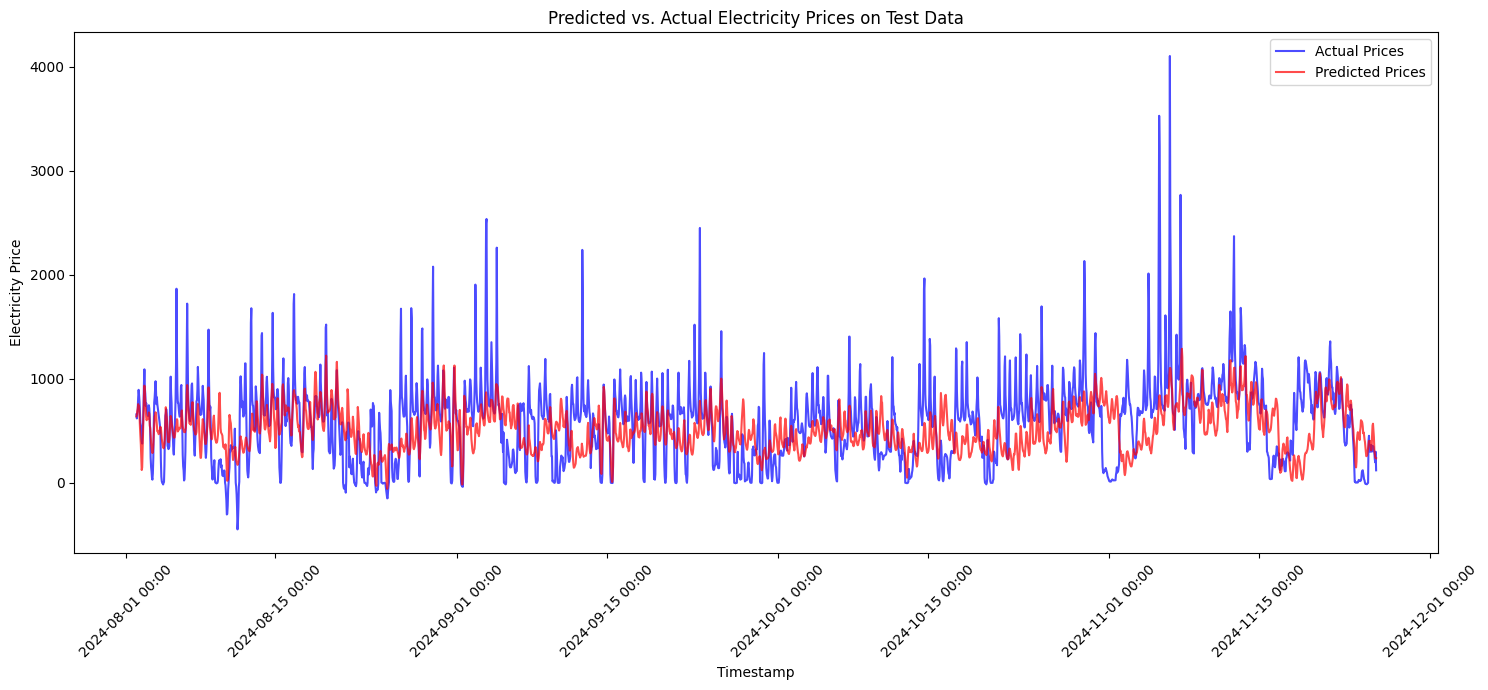

In [18]:
# convert 'predictions' and 'actuals' to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# extract 'from' timestamps from test_data, adjusted for seq_length
# since the dataset uses sequences, the first 'seq_length' targets are not included in 'actuals' and 'predictions'
test_timestamps = test_data['from'].values[seq_length:]

# ensure lengths match
min_length = min(len(test_timestamps), len(actuals), len(predictions))
test_timestamps = test_timestamps[:min_length]
actuals = actuals[:min_length]
predictions = predictions[:min_length]

# create the plot
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/lstm_predicted_vs_actual_prices2024.png')

plt.show()

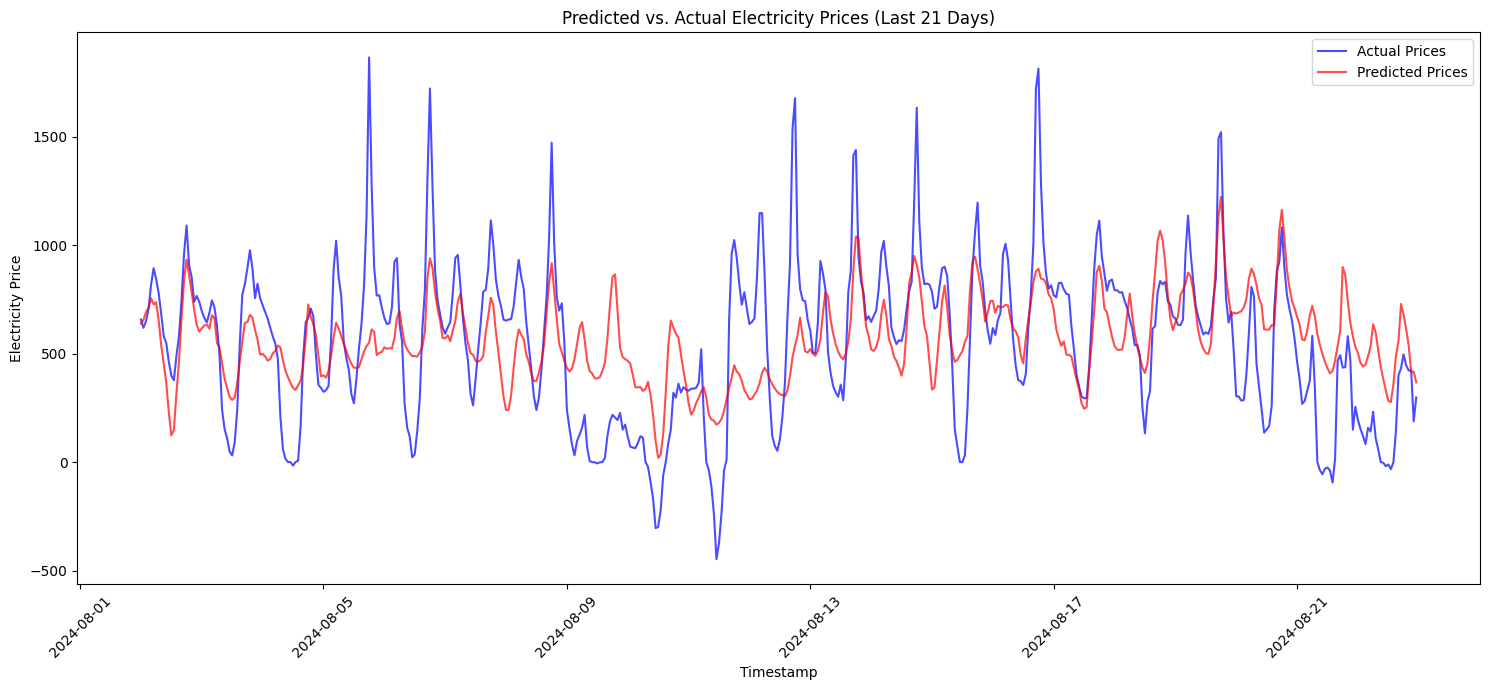

In [19]:
# plot the first 500 data points
datapoints = 24*21
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps[:datapoints], actuals[:datapoints], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps[:datapoints], predictions[:datapoints], label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title(f'Predicted vs. Actual Electricity Prices (Last {datapoints//24} Days)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f'output/lstm_predicted_vs_actual_prices_last{datapoints//24}days.png')
plt.show()


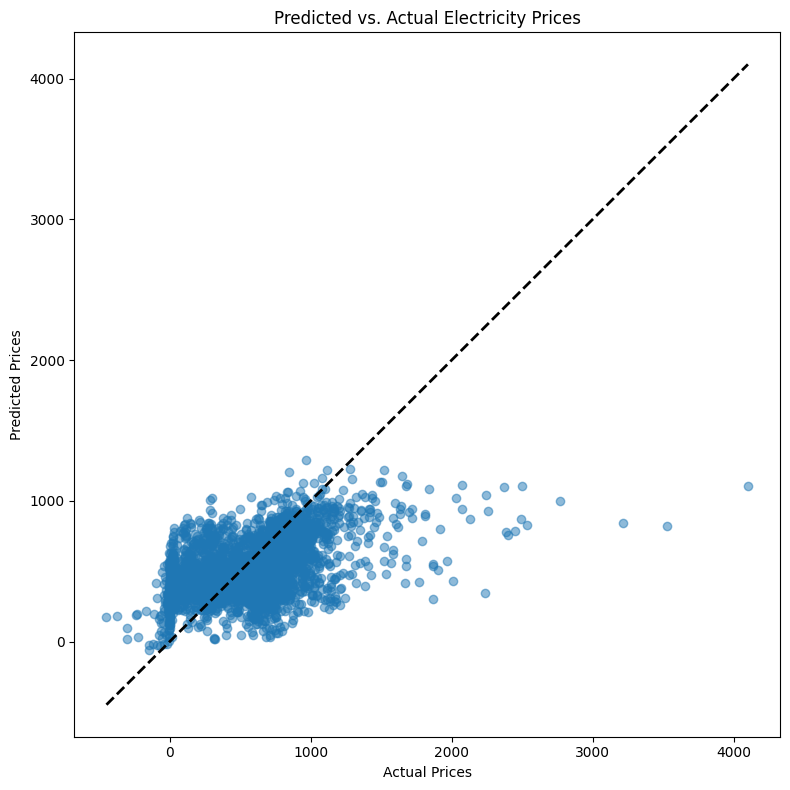

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Electricity Prices')

# Plot a diagonal line for reference
min_price = min(actuals.min(), predictions.min())
max_price = max(actuals.max(), predictions.max())
plt.plot([min_price, max_price], [min_price, max_price], 'k--', lw=2)
plt.tight_layout()

plt.savefig('output/lstm_predicted_vs_actual_prices_scatter.png')
plt.show()